In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

import sys
import importlib

sys.path.append(r"C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\8Q_Triangle_Lattice_v1")

import correlation_measurements.src_correlation_measurement
importlib.reload(correlation_measurements.src_correlation_measurement)
from correlation_measurements.src_correlation_measurement import RampOscillationShotsMeasurement, generate_ramp_double_jump_correlations_filename

import src.src_current_measurement
importlib.reload(src.src_current_measurement);
from src.src_current_measurement import CurrentMeasurementCalibration, generate_current_calibration_filename, acquire_data, generate_ramp_beamsplitter_correlations_filename, generate_ramp_beamsplitter_correlations_clean_filename



In [2]:
def plot_post_selected_covariance_sum(measurement, covariance_sum, readout_pair_1, readout_pair_2, beamsplitter_time=None, ylim=None):
   
    times = measurement.get_times()

    plt.plot(times, covariance_sum, 'o--')
    plt.xlabel('Time (ns)')
    plt.ylabel('Current Correlation')

    if ylim is not None:
        plt.ylim(*ylim)

    if beamsplitter_time is not None:
        plt.axvline(beamsplitter_time, color='r', alpha=0.4, linestyle='--', label='Beamsplitter Time')

    correlator_symbol = f'$\\langle j_{{{readout_pair_1[0]+1}{readout_pair_1[1]+1}}}j_{{{readout_pair_2[0]+1}{readout_pair_2[1]+1}}}\\rangle$ '
    plt.title(f'Post-Selected Current Correlations {correlator_symbol} for 8 qubits')
    plt.show()




In [3]:
def calculate_population_from_counts(counts, basis=None, readout_pair_1=[0,1], readout_pair_2=[2,3]):
    """
    Compute single-qubit populations for the four qubits in readout_pair_1 and readout_pair_2.
    """
    if not abs(readout_pair_1[1] - readout_pair_1[0]) == 1:
        raise ValueError(f'readout pair qubits must be sequential, given: {readout_pair_1}')
    if not abs(readout_pair_2[1] - readout_pair_2[0]) == 1:
        raise ValueError(f'readout pair qubits must be sequential, given: {readout_pair_2}')

    if basis is None:
        basis = list(product(range(2), repeat=int(math.log2(counts.shape[0]))))

    # Normalize counts to probabilities per time slice
    counts = counts / np.sum(counts, axis=0, keepdims=True)

    qubit_indices = readout_pair_1 + readout_pair_2
    population_average = np.zeros((4, counts.shape[-1]))

    # Compute <n_i> for each of the four qubits of interest
    for i, q_index in enumerate(qubit_indices):
        for outcome_idx, outcome in enumerate(basis):
            if outcome[q_index] == 1:
                population_average[i, :] += counts[outcome_idx, :]

    return population_average


def calculate_current_correlation_from_counts(counts, population_average=None, basis=None,
                                              readout_pair_1=[0,1], readout_pair_2=[2,3]):
    """
    Compute the current correlation
    O = <n1 n3> - <n1 n4> - <n2 n3> + <n2 n4>,
    using properly normalized post-selected counts.
    """

    if not abs(readout_pair_1[1] - readout_pair_1[0]) == 1:
        raise ValueError(f'readout pair qubits must be sequential, given: {readout_pair_1}')
    if not abs(readout_pair_2[1] - readout_pair_2[0]) == 1:
        raise ValueError(f'readout pair qubits must be sequential, given: {readout_pair_2}')

    if basis is None:
        basis = list(product(range(2), repeat=int(math.log2(counts.shape[0]))))

    # Normalize counts after post-selection → makes probabilities conditional
    counts = counts / np.sum(counts, axis=0, keepdims=True)

    # If not provided, compute populations now
    if population_average is None:
        population_average = calculate_population_from_counts(
            counts, basis=basis, readout_pair_1=readout_pair_1, readout_pair_2=readout_pair_2
        )


    # Define the four qubit indices of interest
    q1, q2 = readout_pair_1
    q3, q4 = readout_pair_2

    # Compute all pairwise <n_i n_j>
    pair_means = np.zeros((4, counts.shape[-1]))
    pair_indices = [(q1, q3), (q1, q4), (q2, q3), (q2, q4)]

    for k, (i_idx, j_idx) in enumerate(pair_indices):
        outcome_count = np.zeros(counts.shape[-1])
        for outcome_idx, outcome in enumerate(basis):
            if outcome[i_idx] == 1 and outcome[j_idx] == 1:
                outcome_count += counts[outcome_idx, :]
        pair_means[k, :] = outcome_count  # Already normalized

    # Compute <n_i> values for subtraction
    n1, n2, n3, n4 = population_average

    # Covariances
    n1n3 = pair_means[0, :] - n1 * n3
    n1n4 = pair_means[1, :] - n1 * n4
    n2n3 = pair_means[2, :] - n2 * n3
    n2n4 = pair_means[3, :] - n2 * n4

    # Combine into current correlation
    current_correlations = n1n3 - n1n4 - n2n3 + n2n4

    return current_correlations


In [4]:
### define mapping from correlation pair to beamsplitter configuration

correlation_pair_to_configuration = {}

# all d=2,4,6 correlations
configuration_12_34_56_78 = '12-34-56-78'
correlation_pair_to_configuration[((1,2),(3,4))] = configuration_12_34_56_78
correlation_pair_to_configuration[((1,2),(5,6))] = configuration_12_34_56_78
correlation_pair_to_configuration[((1,2),(7,8))] = configuration_12_34_56_78

correlation_pair_to_configuration[((3,4),(5,6))] = configuration_12_34_56_78
correlation_pair_to_configuration[((3,4),(7,8))] = configuration_12_34_56_78

correlation_pair_to_configuration[((5,6),(7,8))] = configuration_12_34_56_78

configuration_1_23_45_67_8 = '1-23-45-67-8'
correlation_pair_to_configuration[((2,3),(4,5))] = configuration_1_23_45_67_8
correlation_pair_to_configuration[((2,3),(6,7))] = configuration_1_23_45_67_8

correlation_pair_to_configuration[((4,5),(6,7))] = configuration_1_23_45_67_8

# all d=3 correlations
correlation_pair_to_configuration[((1,2),(4,5))] = '12-3-45-6-7-8'
correlation_pair_to_configuration[((2,3),(5,6))] = '1-23-4-56-7-8'
correlation_pair_to_configuration[((3,4),(6,7))] = '1-2-34-5-67-8'
correlation_pair_to_configuration[((4,5),(7,8))] = '1-2-3-45-6-78'

# all d=5 correlations
correlation_pair_to_configuration[((1,2),(6,7))] = '12-3-4-5-67-8'
correlation_pair_to_configuration[((2,3),(7,8))] = '1-23-4-5-6-78'


In [5]:
configuration_to_filename = {}

# 11/04/25
configuration_to_filename['12-34-56-78'] = generate_ramp_beamsplitter_correlations_filename('2025', '11', '04', '12', '54', '01') # high quality 1234

# 11/05/25
configuration_to_filename['1-23-45-67-8'] = generate_ramp_beamsplitter_correlations_filename('2025', '11', '05', '11', '02', '40') # low quality 2345
configuration_to_filename['1-23-45-67-8'] = generate_ramp_beamsplitter_correlations_filename('2025', '11', '05', '11', '15', '26') # high quality 2345


configuration_to_filename['12-3-45-6-7-8'] = generate_ramp_beamsplitter_correlations_filename('2025', '11', '05', '13', '16', '24') # high quality 1245

configuration_to_filename['12-3-4-5-67-8'] = generate_ramp_beamsplitter_correlations_filename('2025', '11', '05', '13', '16', '24') # high quality 1267

configuration_to_filename['1-23-4-56-7-8'] = generate_ramp_beamsplitter_correlations_filename('2025', '11', '05', '18', '04', '26') # high quality 2356

configuration_to_filename['1-23-4-5-6-78'] = generate_ramp_beamsplitter_correlations_filename('2025', '11', '05', '21', '18', '24') # high quality 2378

# 11/06/25
configuration_to_filename['1-2-34-5-67-8'] = generate_ramp_beamsplitter_correlations_filename('2025', '11', '06', '10', '52', '49') # high quality 3467

configuration_to_filename['1-2-3-45-6-78'] = generate_ramp_beamsplitter_correlations_filename('2025', '11', '06', '15', '15', '41') # high quality 4578

# 11/07/25
configuration_to_filename['1-2-3-45-6-78'] = generate_ramp_beamsplitter_correlations_filename('2025', '11', '07', '10', '15', '36') # low quality 4578
configuration_to_filename['1-2-3-45-6-78'] = generate_ramp_beamsplitter_correlations_filename('2025', '11', '07', '10', '18', '14') # high quality 4578

configuration_to_filename['1-2-3-45-6-78'] = generate_ramp_beamsplitter_correlations_filename('2025', '11', '07', '13', '29', '06') # low quality 4578

# 11/10/25
configuration_to_filename['1-2-3-45-6-78'] = generate_ramp_beamsplitter_correlations_filename('2025', '11', '10', '11', '43', '58') # low quality 4578
configuration_to_filename['1-2-3-45-6-78'] = generate_ramp_beamsplitter_correlations_filename('2025', '11', '10', '12', '27', '11') # high quality 4578

# change 45 phase by pi
# configuration_to_filename['1-2-3-45-6-78'] = generate_ramp_beamsplitter_correlations_filename('2025', '11', '10', '13', '05', '14') # low quality 4578
# configuration_to_filename['1-2-3-45-6-78'] = generate_ramp_beamsplitter_correlations_filename('2025', '11', '10', '13', '30', '28') # high quality 4578



configuration_to_measurement = {}
for configuration in configuration_to_filename:
    configuration_to_measurement[configuration] = RampOscillationShotsMeasurement(configuration_to_filename[configuration])

In [9]:
# reduced correlations

correlation_pairs = []


# d=2
correlation_pairs.append(((1,2),(3,4)))
correlation_pairs.append(((2,3),(4,5)))
correlation_pairs.append(((3,4),(5,6)))
correlation_pairs.append(((4,5),(6,7)))
correlation_pairs.append(((5,6),(7,8)))

# d=3
correlation_pairs.append(((1,2),(4,5)))
correlation_pairs.append(((2,3),(5,6)))
correlation_pairs.append(((3,4),(6,7)))
correlation_pairs.append(((4,5),(7,8)))

# d=4
correlation_pairs.append(((1,2),(5,6)))
correlation_pairs.append(((2,3),(6,7)))
correlation_pairs.append(((3,4),(7,8)))

# d=5
correlation_pairs.append(((1,2),(6,7)))
correlation_pairs.append(((2,3),(7,8)))

# d=6
correlation_pairs.append(((1,2),(7,8)))

In [7]:
correlation_pairs = []

correlation_pairs.append(((4,5),(7,8)))


In [ ]:
# ### only run if you want to recalculate all correlation data from raw counts

# correlation_pair_to_correlation_data = {}
# correlation_pair_to_correlations = {}
# correlation_pair_to_population_data = {}

In [12]:
### plot post selected data


post_select = True
confusion_matrix_correct = True

plot_individual_terms = False


beamsplitter_time = 25

ylim = (-0.35, 0.35)
ylim = (-0.4, 0.4)

basis = list(product([0,1], repeat=8))



for correlation_pair in correlation_pairs:

    if not correlation_pair in correlation_pair_to_configuration:
        continue

    configuration = correlation_pair_to_configuration[correlation_pair]

    if not configuration in configuration_to_measurement:
        continue
    measurement = configuration_to_measurement[configuration]

    readout_qubits_1, readout_qubits_2 = correlation_pair

    readout_pair_1 = [q - 1 for q in readout_qubits_1]
    readout_pair_2 = [q - 1 for q in readout_qubits_2]



    print(f'Correlation pair: {correlation_pair}:')
    print(f'Configuration: {configuration}:')

    print(f'beamsplitter time: {beamsplitter_time:.2f} ns')

    
    ### correct and post select

    # maintain the same shape as counts, but just zero out the unwanted bitstrings
    num_particles = 4

    counts = measurement.get_counts()


   
    if confusion_matrix_correct:
        confusion_matrices = measurement.get_confusion_matrices()
        confusion_inverse_matrices = np.array([np.linalg.inv(confusion_matrix) for confusion_matrix in confusion_matrices])

        joint_confusion_inverse_matrix = confusion_inverse_matrices[0]
        for i in range(1, confusion_inverse_matrices.shape[0]):
            joint_confusion_inverse_matrix = np.kron(joint_confusion_inverse_matrix, confusion_inverse_matrices[i])


        counts_corrected = joint_confusion_inverse_matrix @ counts

    else:
        counts_corrected = counts


    counts_post_selected = np.zeros_like(counts)
    counts_corrected_post_selected = np.zeros_like(counts)

    if post_select:
        for i, outcome in enumerate(basis):
            if sum(outcome) == num_particles:
                counts_post_selected[i, :] = counts[i, :]
                counts_corrected_post_selected[i, :] = counts_corrected[i, :]
    else:
        counts_post_selected = counts
        counts_corrected_post_selected = counts_corrected

    covariance_sum = calculate_current_correlation_from_counts(counts_corrected_post_selected, population_average=None,
                                                               basis=basis, readout_pair_1=readout_pair_1, readout_pair_2=readout_pair_2)

    populations = calculate_population_from_counts(counts_corrected_post_selected, basis=basis, readout_pair_1=readout_pair_1, readout_pair_2=readout_pair_2)

    correlation_pair_to_correlation_data[correlation_pair] = covariance_sum
    correlation_pair_to_population_data[correlation_pair] = populations

    # plot_post_selected_covariance_sum(measurement, covariance_sum, readout_pair_1, readout_pair_2, beamsplitter_time=beamsplitter_time, ylim=ylim)


    current_correlation_index = np.argmin(np.abs(measurement.get_times() - beamsplitter_time))
    current_correlation_value = covariance_sum[current_correlation_index]

    correlation_pair_to_correlations[correlation_pair] = current_correlation_value

    print(f'Current correlation at beamsplitter time for rungs ({readout_pair_1[0]+1},{readout_pair_1[1]+1}) and ({readout_pair_2[0]+1},{readout_pair_2[1]+1}): {current_correlation_value:.4f}')



Correlation pair: ((1, 2), (3, 4)):
Configuration: 12-34-56-78:
beamsplitter time: 25.00 ns
Current correlation at beamsplitter time for rungs (1,2) and (3,4): 0.2248
Correlation pair: ((2, 3), (4, 5)):
Configuration: 1-23-45-67-8:
beamsplitter time: 25.00 ns
Current correlation at beamsplitter time for rungs (2,3) and (4,5): 0.1254
Correlation pair: ((3, 4), (5, 6)):
Configuration: 12-34-56-78:
beamsplitter time: 25.00 ns
Current correlation at beamsplitter time for rungs (3,4) and (5,6): 0.1000
Correlation pair: ((4, 5), (6, 7)):
Configuration: 1-23-45-67-8:
beamsplitter time: 25.00 ns
Current correlation at beamsplitter time for rungs (4,5) and (6,7): 0.1248
Correlation pair: ((5, 6), (7, 8)):
Configuration: 12-34-56-78:
beamsplitter time: 25.00 ns
Current correlation at beamsplitter time for rungs (5,6) and (7,8): 0.1918
Correlation pair: ((1, 2), (4, 5)):
Configuration: 12-3-45-6-7-8:
beamsplitter time: 25.00 ns
Current correlation at beamsplitter time for rungs (1,2) and (4,5): 0

In [13]:
correlation_pair_to_beamsplitter_time = {}

beamsplitter_time_default = 25


correlation_pair_to_beamsplitter_time[((1,2),(3,4))] = beamsplitter_time_default
correlation_pair_to_beamsplitter_time[((1,2),(4,5))] = beamsplitter_time_default
correlation_pair_to_beamsplitter_time[((1,2),(5,6))] = beamsplitter_time_default
correlation_pair_to_beamsplitter_time[((1,2),(6,7))] = beamsplitter_time_default
correlation_pair_to_beamsplitter_time[((1,2),(7,8))] = beamsplitter_time_default - 2

correlation_pair_to_beamsplitter_time[((2,3),(4,5))] = beamsplitter_time_default
correlation_pair_to_beamsplitter_time[((2,3),(5,6))] = beamsplitter_time_default
correlation_pair_to_beamsplitter_time[((2,3),(6,7))] = beamsplitter_time_default
correlation_pair_to_beamsplitter_time[((2,3),(7,8))] = beamsplitter_time_default

correlation_pair_to_beamsplitter_time[((3,4),(5,6))] = beamsplitter_time_default
correlation_pair_to_beamsplitter_time[((3,4),(6,7))] = beamsplitter_time_default
correlation_pair_to_beamsplitter_time[((3,4),(7,8))] = beamsplitter_time_default

correlation_pair_to_beamsplitter_time[((4,5),(6,7))] = beamsplitter_time_default - 1
correlation_pair_to_beamsplitter_time[((4,5),(7,8))] = beamsplitter_time_default

correlation_pair_to_beamsplitter_time[((5,6),(7,8))] = beamsplitter_time_default - 2

In [84]:
correlation_pairs = []

correlation_pairs.append(((1,2),(4,5)))
correlation_pairs.append(((2,3),(5,6)))
correlation_pairs.append(((3,4),(6,7)))
correlation_pairs.append(((4,5),(7,8)))


# correlation_pairs.append(((1,2),(7,8)))


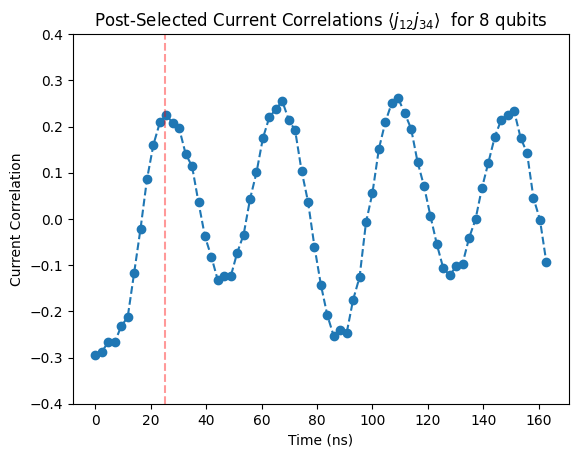

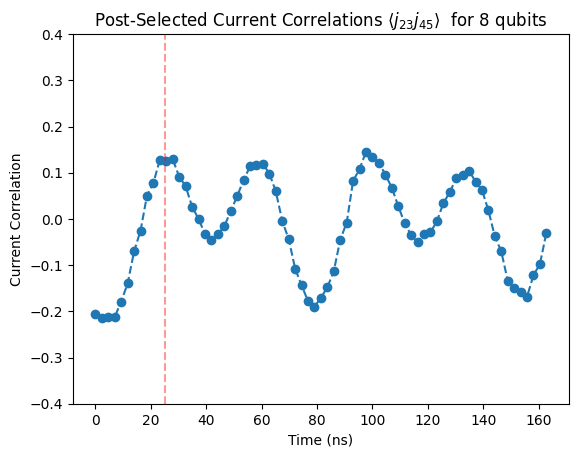

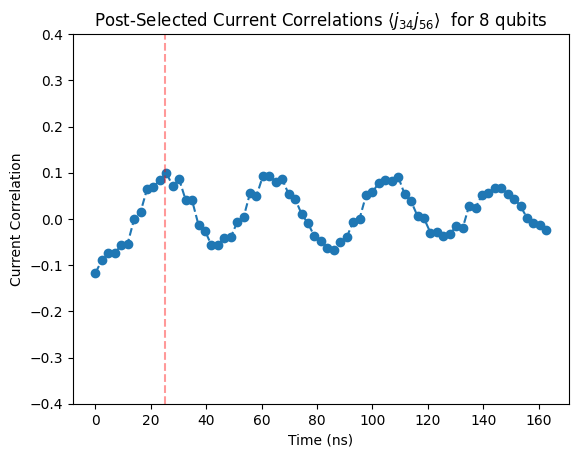

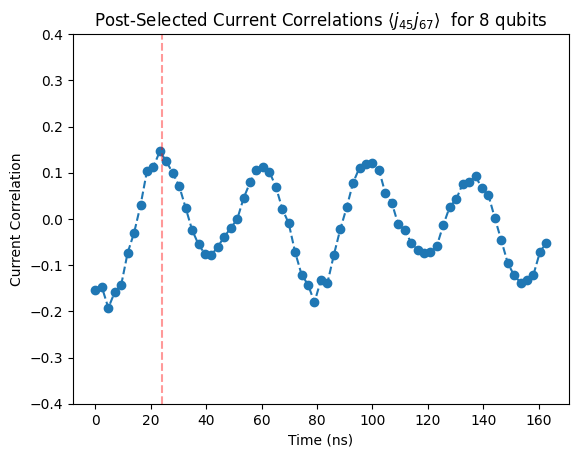

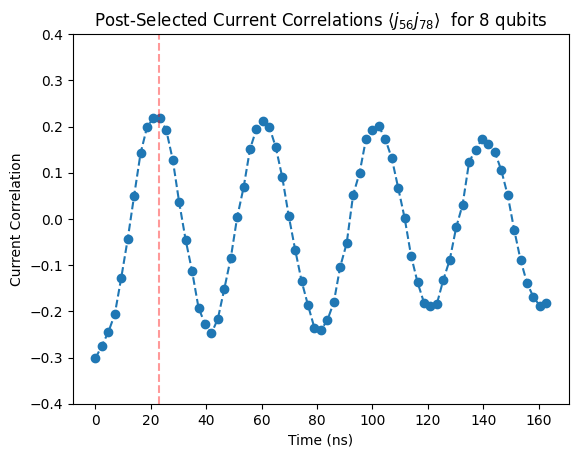

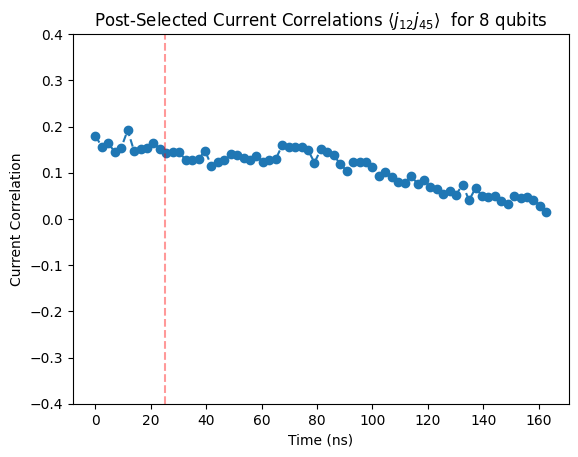

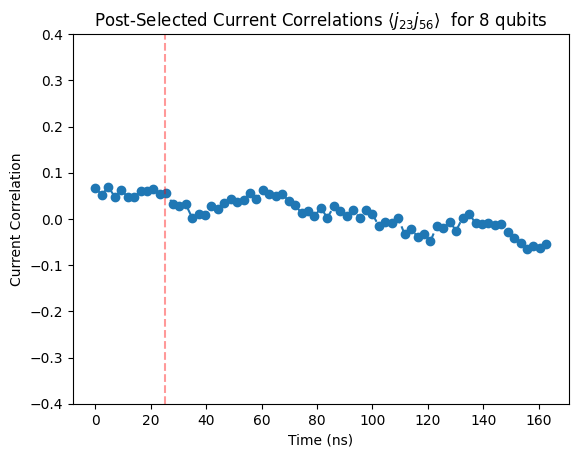

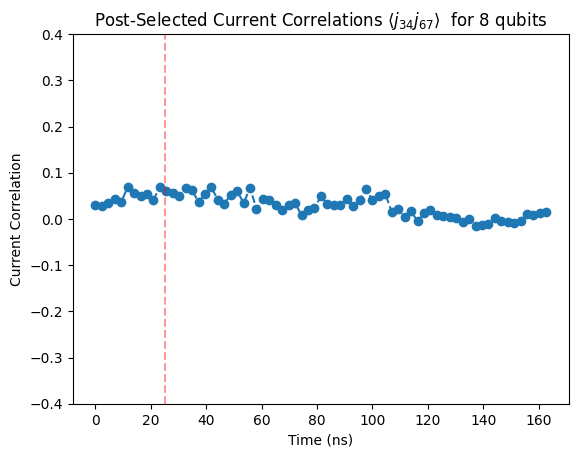

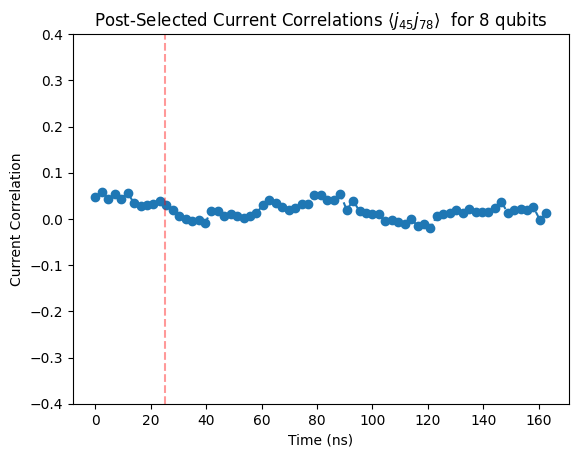

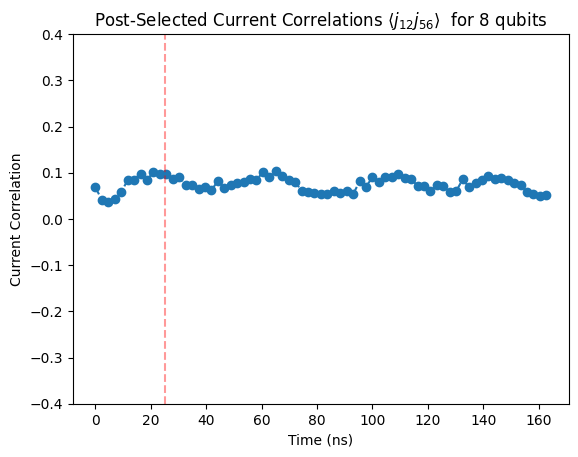

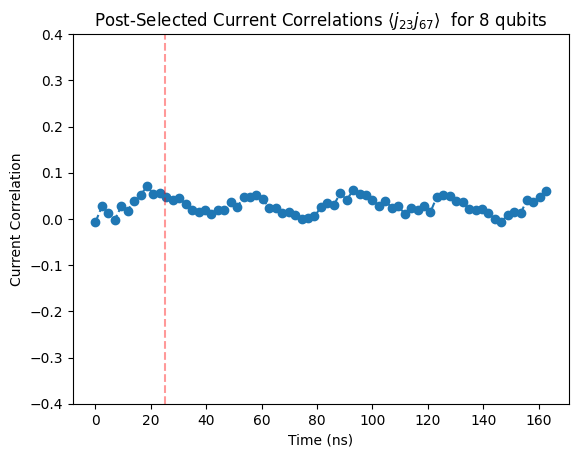

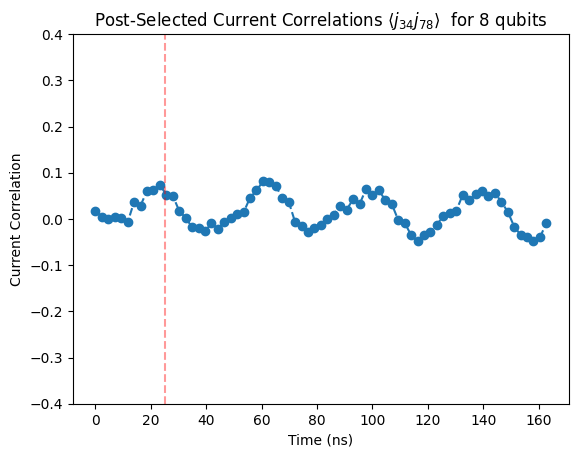

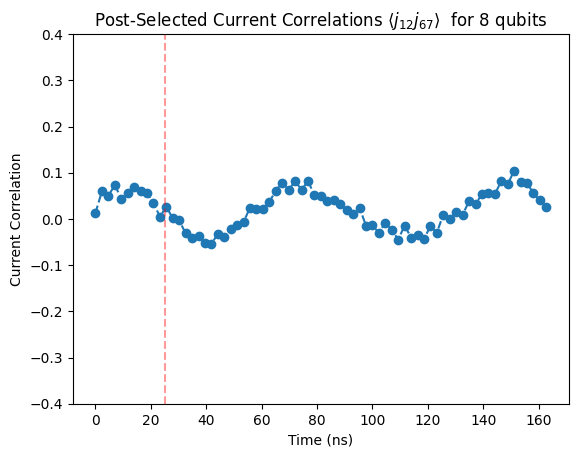

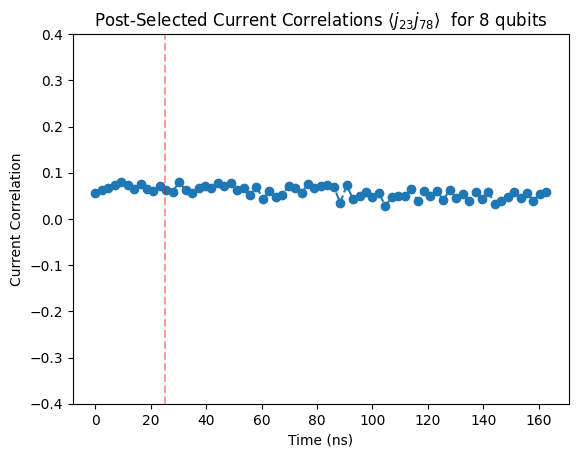

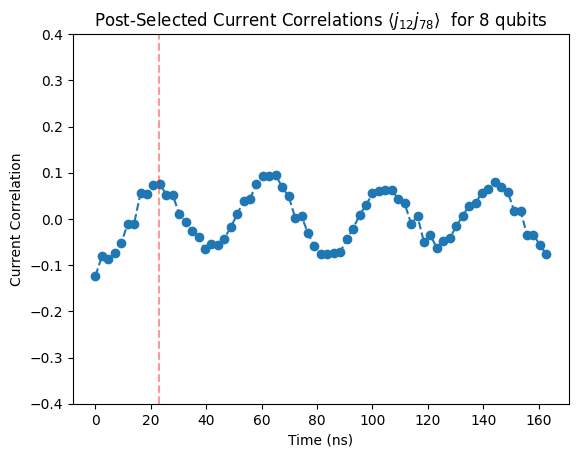

In [14]:
### plot current correlation

ylim = (-0.4, 0.4)

for correlation_pair in correlation_pairs:

    if correlation_pair not in correlation_pair_to_correlation_data:
        continue

    covariance_sum = correlation_pair_to_correlation_data[correlation_pair]
    readout_qubits_1, readout_qubits_2 = correlation_pair

    readout_pair_1 = [q - 1 for q in readout_qubits_1]
    readout_pair_2 = [q - 1 for q in readout_qubits_2]

    plot_post_selected_covariance_sum(measurement, covariance_sum, readout_pair_1, readout_pair_2, beamsplitter_time=correlation_pair_to_beamsplitter_time[correlation_pair], ylim=ylim)

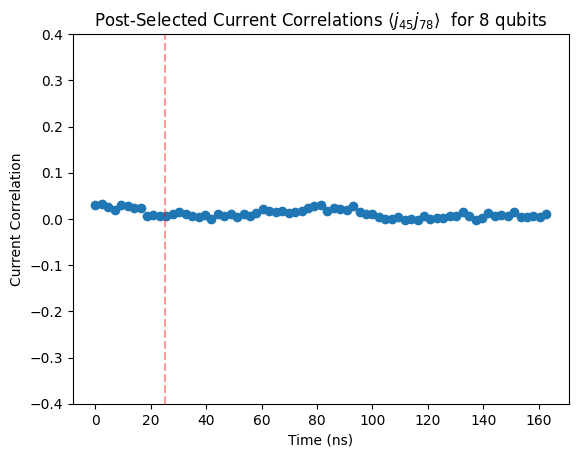

Distance: 2, Correlation: 0.2248
Distance: 2, Correlation: 0.1254
Distance: 2, Correlation: 0.1000
Distance: 2, Correlation: 0.1248
Distance: 2, Correlation: 0.1918
Distance: 3, Correlation: 0.1418
Distance: 3, Correlation: 0.0552
Distance: 3, Correlation: 0.0603
Distance: 3, Correlation: 0.0311
Distance: 4, Correlation: 0.0981
Distance: 4, Correlation: 0.0468
Distance: 4, Correlation: 0.0529
Distance: 5, Correlation: 0.0261
Distance: 5, Correlation: 0.0633
Distance: 6, Correlation: 0.0521


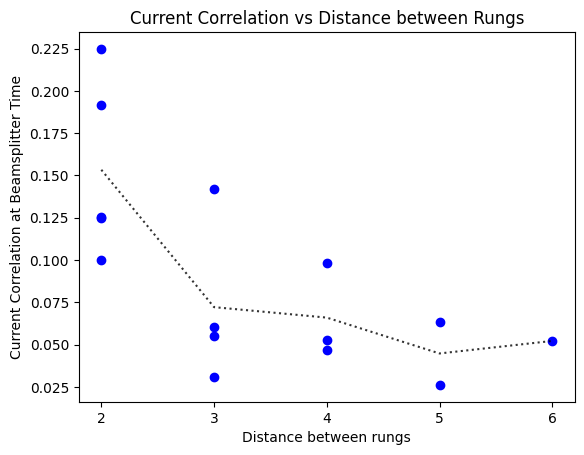

In [16]:
### plot correlation values vs distance

distance_to_average_values = {i: 0 for i in range(2,7)}

for correlation_pair in correlation_pair_to_correlations:
    distance = abs(correlation_pair[0][0] - correlation_pair[1][0])
    correlation_value = correlation_pair_to_correlations[correlation_pair]
    print(f'Distance: {distance}, Correlation: {correlation_value:.4f}')

    distance_to_average_values[distance] += correlation_value

    plt.scatter(distance, correlation_value, color='b')


distances = []
average_values = []
for distance in distance_to_average_values:
    distances.append(distance)
    average_values.append(distance_to_average_values[distance]/(7-distance))

plt.xlabel('Distance between rungs')
plt.ylabel('Current Correlation at Beamsplitter Time')
plt.title('Current Correlation vs Distance between Rungs')

plt.xticks(range(1, 7), [1, 2, 3, 4, 5, 6])

plt.plot(distances, average_values, linestyle=':', color='black', alpha=0.8)

plt.show()

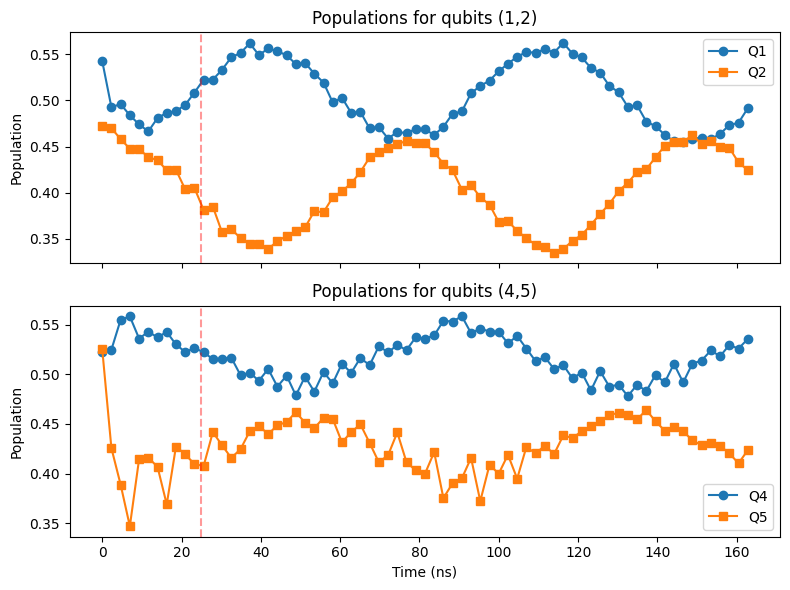

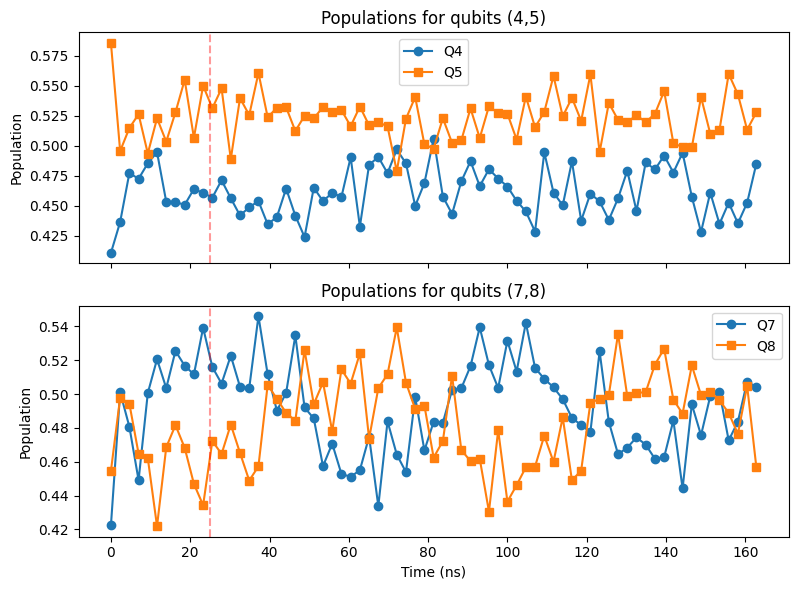

In [89]:
### plot population swaps

plot_populations_correlation_pairs = []

plot_populations_correlation_pairs.append(((1,2),(4,5)))
plot_populations_correlation_pairs.append(((4,5),(7,8)))

for correlation_pair in plot_populations_correlation_pairs:

    if not correlation_pair in correlation_pair_to_population_data:
        continue

    population_data = correlation_pair_to_population_data[correlation_pair]

    readout_qubits_1, readout_qubits_2 = correlation_pair
    q1, q2 = readout_qubits_1
    q3, q4 = readout_qubits_2

    times = measurement.get_times()

    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    # first pair
    axes[0].plot(times, population_data[0, :], 'o-', label=f'Q{q1}')
    axes[0].plot(times, population_data[1, :], 's-', label=f'Q{q2}')
    axes[0].set_ylabel('Population')
    axes[0].set_title(f'Populations for qubits ({q1},{q2})')
    axes[0].legend()

    # second pair
    axes[1].plot(times, population_data[2, :], 'o-', label=f'Q{q3}')
    axes[1].plot(times, population_data[3, :], 's-', label=f'Q{q4}')
    axes[1].set_xlabel('Time (ns)')
    axes[1].set_ylabel('Population')
    axes[1].set_title(f'Populations for qubits ({q3},{q4})')
    axes[1].legend()

    if beamsplitter_time is not None:
        for ax in axes:
            ax.axvline(beamsplitter_time, color='r', alpha=0.4, linestyle='--')

    plt.tight_layout()
    plt.show()



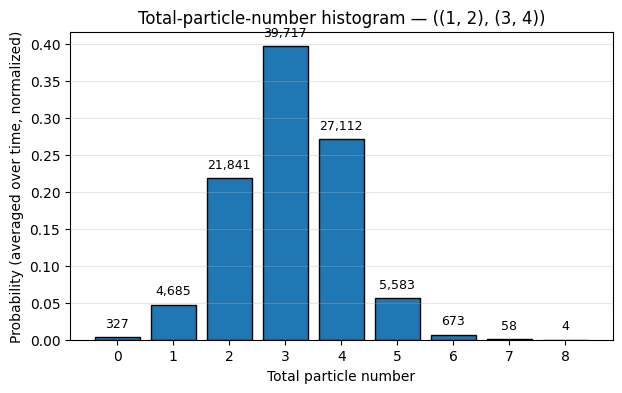

In [64]:
plot_histogram_correlation_pairs = []

plot_histogram_correlation_pairs.append(((1,2),(3,4)))

basis = list(product(range(2),repeat=8))
for correlation_pair in plot_histogram_correlation_pairs:

    configuration = correlation_pair_to_configuration[correlation_pair]
    measurement = configuration_to_measurement[configuration]

    # use uncorrected and un-post-selected counts
    counts = measurement.get_counts()

    # average counts over time, bin by total particle number (0..8), normalize and plot

    # mean occurrences per bitstring across all time bins
    mean_counts_per_bitstring = counts.mean(axis=1)

    # compute total particle number for each basis element
    particle_numbers = np.array([sum(b) for b in basis])

    # sum mean counts for each total particle number
    hist = np.zeros(9)
    for n in range(9):
        hist[n] = mean_counts_per_bitstring[particle_numbers == n].sum()

    # normalize to unit sum (handle the zero-sum case)
    total = hist.sum()
    if total > 0:
        hist = hist / total

    # compute raw total occurrences (mean counts summed over bitstrings) for each total-particle number
    counts_per_n = np.zeros(9, dtype=float)
    for n in range(9):
        counts_per_n[n] = mean_counts_per_bitstring[particle_numbers == n].sum()
    counts_labels = np.round(counts_per_n).astype(int)

    # wrap plt.bar so labels are added automatically when the bar chart is created below
    _orig_bar = plt.bar
    def _bar_with_labels(*args, **kwargs):
        bars = _orig_bar(*args, **kwargs)
        for i, b in enumerate(bars):
            h = b.get_height()
            x = b.get_x() + b.get_width() / 2
            # place label slightly above the bar
            plt.text(x, h + 0.01, f'{counts_labels[i]:,}', ha='center', va='bottom', fontsize=9)
        return bars
    plt.bar = _bar_with_labels

    # plot
    plt.figure(figsize=(7,4))
    plt.bar(range(9), hist, color='C0', edgecolor='k')
    plt.xticks(range(9))
    plt.xlabel('Total particle number')
    plt.ylabel('Probability (averaged over time, normalized)')
    plt.title(f'Total-particle-number histogram — {correlation_pair}')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

